<a href="https://colab.research.google.com/github/nbchan/INMR96-Digital-Health-and-Data-Analytics/blob/main/Week_08_Training%2C_Evaluating_and_Tuning_Models_(III).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIMIC-III Example: Hospital Length-of-Stay Prediction

---

# 1. Objectives

This notebook serves as an example to demonstrate the codes for training machine learning models for a regression problem instead of a classification problem. In actuality, using the following list of input features is most likely flawed as hospital stay-normalized variables such as `LAB_COUNT_DAY` is inherently calculated from LOS. Any applications built on this model would likely be problematic.

---

# 2. Setting up

**Packages for data handling and visualization**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()

**Packages for data analysis and modelling**

In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

**Import the intermediate dataset and Authenication for Google Drive access**

If you saved the intermediate dataset in your Google Drive by following all the steps in the previous tutorial, you can grant Colab access to your Google Drive and import the intermediate dataset to the current notebook.

Alternatively, when you are working on your own analysis, you may also put everything (e.g. codes for extracting data from BigQuery; exploring data; preparing and cleaning data; building models) in a single notebook. In that case, you do not need to import the dataset from your Google Drive - simply continue with the cleaned dataset in your existing notebook environment. 


In [3]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount = True) # you would need to authenicate yourself here

gdrive_rootpath = '/content/gdrive/MyDrive/' 
# if you saved the file inside a folder in your Google Drive (instead of the base path), 
# you would need to append the folder name to the above

Mounted at /content/gdrive


In [4]:
df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58976 entries, 0 to 58975
Data columns (total 64 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SUBJECT_ID                        58976 non-null  int64  
 1   HADM_ID                           58976 non-null  int64  
 2   ADMISSION_TYPE                    58976 non-null  object 
 3   ADMITTIME                         58976 non-null  object 
 4   DISCHTIME                         58976 non-null  object 
 5   DEATHTIME                         5854 non-null   object 
 6   DIAGNOSIS                         58951 non-null  object 
 7   MARITAL_STATUS                    58976 non-null  object 
 8   INSURANCE                         58976 non-null  object 
 9   LANGUAGE                          58976 non-null  object 
 10  RELIGION                          58976 non-null  object 
 11  ETHNICITY                         58976 non-null  object 
 12  GEND

In [6]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,IN_HOSP_DEATH,AGE,LOS,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,RELIGION_CATHOLIC,RELIGION_NOT SPECIFIED,RELIGION_UNOBTAINABLE,RELIGION_OTHERS,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Medicaid,INSURANCE_OTHERS,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaN,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11 00:00:00,1.3848,1.0,15,44.0,1.0,7.0,182.0,0.0,18.0,0.0,3,47.0,0,60,4.164583,0.200000,8.800000,0.200000,1.400000,36.4,0.000000,3.6,0.000000,0.600000,9.400000,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaN,MVA;TRAUMA,SINGLE,Government,ENGL,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23 00:00:00,3.2653,0.0,9,0.0,9.0,0.0,408.0,331.0,0.0,89.0,3,27.0,0,18,11.112500,0.000000,0.000000,0.750000,0.000000,34.0,27.583333,0.0,7.416667,0.250000,2.250000,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaN,INFECTED RIGHT FOOT,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2096-08-27 00:00:00,3.2458,0.0,9,0.0,8.0,0.0,574.0,390.0,0.0,90.0,6,46.0,0,70,13.895833,0.000000,0.000000,0.571429,0.000000,41.0,27.857143,0.0,6.428571,0.428571,3.285714,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaN,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29 00:00:00,1.7603,1.0,15,30.0,2.0,8.0,207.0,0.0,21.0,20.0,4,0.0,0,90,5.634722,0.166667,5.000000,0.333333,1.333333,34.5,0.000000,3.5,3.333333,0.666667,0.000000,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaN,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16 00:00:00,5.5894,0.0,22,53.0,6.0,10.0,378.0,165.0,0.0,115.0,7,5.0,0,76,5.585417,0.000000,8.833333,1.000000,1.666667,63.0,27.500000,0.0,19.166667,1.166667,0.833333,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0


---

# 2. Training, Evaluating and Tuning Models

## 2.1. Train-test Split

We will split the dataset into a training set and a test set with the same codes included in the previous tutorial. 

`LOS` would be our prediction target. Here, let's define a list of *36* column names for features/inputs we would use in the model as not all columns are appropriate (e.g. `SUBJECT_ID`). 

In [7]:
# the only features excluded from the mortality prediction example are 'LOS' and 'LOS_ICU'
features_list = ['GENDER_F', 'AGE', 
                 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 'PROC_COUNT_DAY',
                 'CPT_COUNT_DAY', 'LAB_COUNT_DAY', 'INPUTS_CV_COUNT_DAY',
                 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
                 'MICRO_COUNT_DAY', 
                 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_NEWBORN', 'ADMISSION_TYPE_URGENT', 
                 'RELIGION_CATHOLIC', 'RELIGION_NOT SPECIFIED', 'RELIGION_UNOBTAINABLE', 'RELIGION_OTHERS', 
                 'INSURANCE_Medicare', 'INSURANCE_Private', 'INSURANCE_Medicaid', 'INSURANCE_OTHERS',
                 'MARITAL_STATUS_MARRIED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_OTHERS',
                 'LANGUAGE_ENGL', 'LANGUAGE_SPAN', 'LANGUAGE_RUSS', 'LANGUAGE_OTHERS',
                 'ETHNICITY_WHITE', 'ETHNICITY_BLACK/AFRICAN AMERICAN', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_OTHERS']

len(features_list)

36

 Then, create a DataFrame containing input features only as well as a Series containing our prediction target. 

In [8]:
X = df[features_list]
y = df['LOS'] # new prediction target

Finally, use `train_test_split()` from the package [Scikit-learn](https://scikit-learn.org/stable/) to perform a train-test split. 

Note that the function outputs four things: the input and output datasets for training and testing respectively. 

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2,  # 20% of data belongs to the test set
                                                    random_state = 1) # make sure the split is the same across different devices for illustrative purposes
# note that we do NOT stratify the train and test sets by category as the values of y are NOT categorical

In [10]:
X_train.shape

(47180, 36)

In [11]:
X_test.shape

(11796, 36)

As a result, our training and test set would include 47,180 and 11,796 admissions respectively. 

---

## 2.2. Training a Random Forest Model

To train a RF regression model instead of a classification model, we use `RandomForestRegressor()` instead of `RandomForestClassifier()`. You can perform hyperparameter tuning by using `GridSearchCV()` in the same way. Model training once again follows the same 3-step process:

1. Specify a model to be trained
2. Train the model with `.fit()`
3. Make predictions with `.predict()`

Define the configuration/hyperparameters of a random forest model. Here we specify that the model contains 200 decision trees.

In [12]:
# 1. Specify a model to be trained
# Also define the configuration/hyperparameters of a random forest model. 
# Here we specify that the model contains 200 decision trees.
model_rf1 = RandomForestRegressor(n_estimators = 200, 
                                     max_depth = 10,
                                     random_state = 1,
                                     n_jobs = -1)

In [13]:
# 2. Train the model
model_rf1.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=200, n_jobs=-1, random_state=1)

In [14]:
# 3. Make predictions
y_pred_rf1 = model_rf1.predict(X_test)
y_pred_rf1

array([86.59406358,  5.5069616 , 99.10844059, ..., 14.49540466,
        1.13299599,  2.62683642])

In [15]:
err_rf1 = y_pred_rf1 - y_test # compute the residuals (error in prediction)

---

### Evaluation

Mean-squared-error (MSE), Root Mean Squared Error (RMSE) and R<sup>2</sup> are common metrics to report. A full list of available metrics could be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter).

In [16]:
# to calculate MSE:
mean_squared_error(y_test, y_pred_rf1)

27.930614848692034

In [17]:
# to calculate RMSE:
mean_squared_error(y_test, y_pred_rf1, squared = False)

5.284942274868481

In [18]:
# to calculate R-squared:
r2_score(y_test, y_pred_rf1)

0.8269649424782766

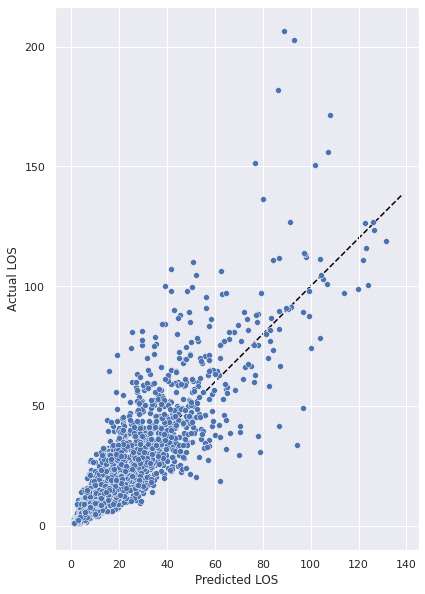

In [19]:
plt.figure(figsize = (10, 10))
g = sns.scatterplot(x = y_pred_rf1, y = y_test)
g.set(xlabel = 'Predicted LOS', ylabel = 'Actual LOS', aspect=1)

# add a predicted=actual line for clarity. Ideally predictions should be close to this line.
diag_line_coor = (0, min(g.get_xlim()[1], g.get_ylim()[1]))
plt.plot(diag_line_coor, diag_line_coor, color="black", ls="--", zorder=0)

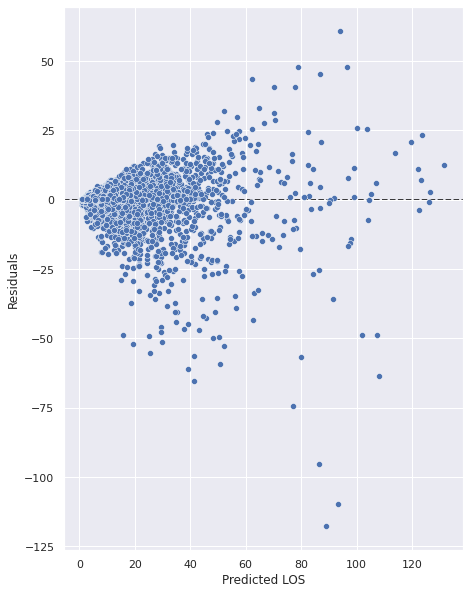

In [20]:
plt.figure(figsize = (10, 10))
g = sns.scatterplot(x = y_pred_rf1, y = err_rf1)
g.set(xlabel = 'Predicted LOS', ylabel = 'Residuals', aspect=1)

# add a horizontal line. Ideally predictions should be close to this line.
plt.axhline(y=0, color="black", ls="--", zorder=0)

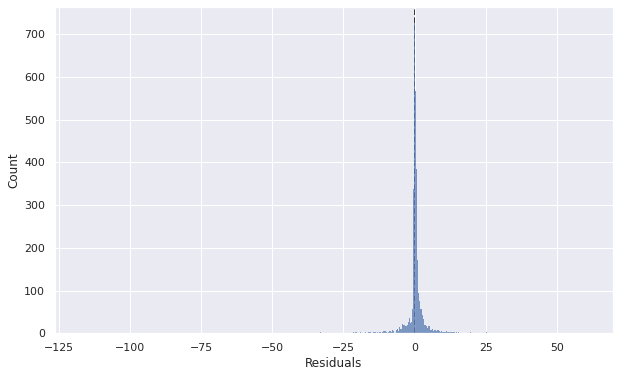

In [21]:
plt.figure(figsize = (10, 6))
g = sns.histplot(err_rf1)
g.set(xlabel = 'Residuals')

# add a vertical line. Ideally predictions should be close to this line.
plt.axvline(x=0, color="black", ls="--", zorder=0)

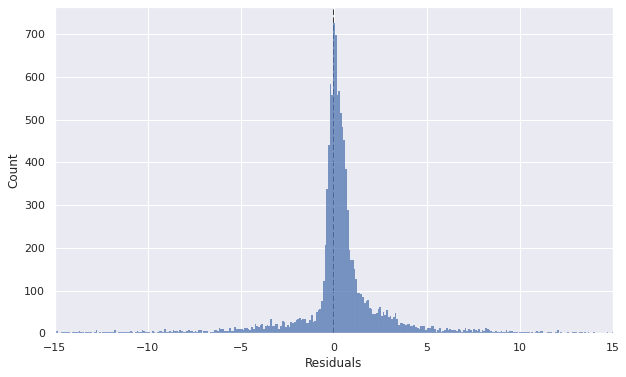

In [22]:
plt.figure(figsize = (10, 6))
g = sns.histplot(err_rf1)
g.set(xlabel = 'Residuals', xlim = (-15, 15)) # specify boundaries for x axis to zoom in

# add a vertical line. Ideally predictions should be close to this line.
plt.axvline(x=0, color="black", ls="--", zorder=0)

[Text(0, 0.5, 'Cumulative Percentage'),
 (0.0, 15.0),
 Text(0.5, 0, 'Absolute Residuals')]

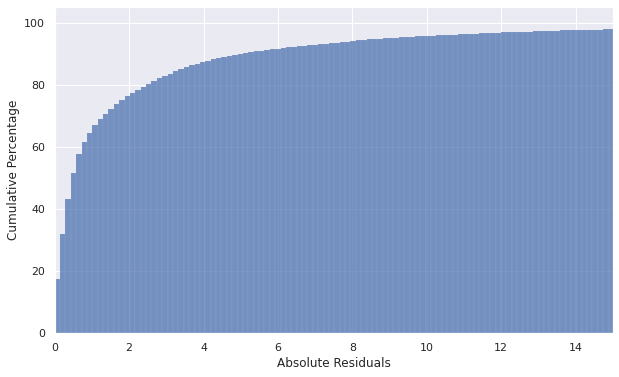

In [23]:
plt.figure(figsize = (10, 6))
g = sns.histplot(abs(err_rf1), cumulative = True, stat = 'percent')
g.set(xlabel = 'Absolute Residuals', ylabel = 'Cumulative Percentage', xlim = (0, 15))

**Some Observations**

* From the residuals against predicted LOS plot, the model is mostly able to predict those with LOS within 48hrs. 

* The model is able to predict LOS within a 3-hr difference 80% of the time.

---

## 2.4. Tuning a Random Forest Model

The codes for hyperparameter tuning are generally the same and this is just another example for your reference. You should always refer to the docs of the model you are using in this step ([RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) in this case). An explanation of Random Forest hyperparameters can also be found [here](https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/).


In [31]:
# a set of hyperparameters and their respective values to be tested

param_grid = {
    'n_estimators': [30, 100, 300],    # number of decision trees in the forest 
    'max_depth': [2, 10, None],        # how many times can each tree be split. 'None' means no specific limit. 
    'min_samples_leaf': [1, 3, 10]     # minimum number of samples required to be at a leaf node. 
}

In [32]:
grid_search_rf = GridSearchCV(
    estimator = RandomForestRegressor(random_state = 1, n_jobs = -1),  # define type of model to be tuned
    param_grid = param_grid,                                           # hyperparameters to be tested
    cv = 5,                                                            # 5-fold cross-validation
    scoring = 'neg_root_mean_squared_error',                           # metric to be optimized. Do not use 'f1' for non-classification problems
    verbose = 2
    )

In [33]:
%%time

grid_search_rf.fit(X_train, y_train)

# this would take **50 minutes** to run
# this could take even longer depending on the number of hyperparameters to be tested, number of folds and the size of the dataset

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=30; total time=   2.2s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=30; total time=   1.3s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=30; total time=   1.3s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=30; total time=   1.3s
[CV] END ...max_depth=2, min_samples_leaf=1, n_estimators=30; total time=   1.3s
[CV] END ..max_depth=2, min_samples_leaf=1, n_estimators=100; total time=   3.5s
[CV] END ..max_depth=2, min_samples_leaf=1, n_estimators=100; total time=   3.7s
[CV] END ..max_depth=2, min_samples_leaf=1, n_estimators=100; total time=   3.6s
[CV] END ..max_depth=2, min_samples_leaf=1, n_estimators=100; total time=   3.6s
[CV] END ..max_depth=2, min_samples_leaf=1, n_estimators=100; total time=   3.7s
[CV] END ..max_depth=2, min_samples_leaf=1, n_estimators=300; total time=  10.6s
[CV] END ..max_depth=2, min_samples_leaf=1, n_e

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1, random_state=1),
             param_grid={'max_depth': [2, 10, None],
                         'min_samples_leaf': [1, 3, 10],
                         'n_estimators': [30, 100, 300]},
             scoring='neg_root_mean_squared_error', verbose=2)

### Tuning Results

Retrieve the best performing set of hyperparams using `.best_params_`

In [35]:
grid_search_rf.best_params_

{'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300}

Retrieve the best performing model from `.best_estimator_` and save it as a seperate variable.

In [36]:
model_rf2 = grid_search_rf.best_estimator_

Use `.cv_results_` in case you want to look into the details of each set of hyperparams. This could help you determine the apprioriate range of each hyperparameter, and thus setting up better `param_grid`'s in any subsequent tuning using more refined ranges. In the example below, we can deduce that having a `max_depth` of 2 is insufficient.

In [37]:
rf_cv_results = pd.DataFrame(grid_search_rf.cv_results_)
rf_cv_results = rf_cv_results.fillna('None')
rf_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.363524,0.358832,0.107013,0.000831,2,1,30,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",-7.202864,-7.696305,-7.191770,-7.665882,-7.128770,-7.377118,0.249664,22
1,3.529833,0.067080,0.106869,0.000810,2,1,100,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",-7.200015,-7.699799,-7.185354,-7.651237,-7.152660,-7.377813,0.244042,25
2,11.294432,1.731261,0.187496,0.040763,2,1,300,"{'max_depth': 2, 'min_samples_leaf': 1, 'n_est...",-7.204292,-7.695422,-7.181439,-7.637965,-7.151096,-7.374043,0.240232,19
3,1.211576,0.034810,0.106511,0.000098,2,3,30,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",-7.202864,-7.696305,-7.191770,-7.665882,-7.128770,-7.377118,0.249664,22
4,3.605734,0.021531,0.106631,0.000215,2,3,100,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",-7.200015,-7.699799,-7.185354,-7.651237,-7.152660,-7.377813,0.244042,25
5,10.681906,0.446804,0.166642,0.049470,2,3,300,"{'max_depth': 2, 'min_samples_leaf': 3, 'n_est...",-7.204292,-7.695422,-7.181439,-7.637965,-7.151096,-7.374043,0.240232,19
6,1.190603,0.030447,0.106416,0.000274,2,10,30,"{'max_depth': 2, 'min_samples_leaf': 10, 'n_es...",-7.202864,-7.696305,-7.191770,-7.665882,-7.128770,-7.377118,0.249664,22
7,3.573979,0.029057,0.106583,0.000186,2,10,100,"{'max_depth': 2, 'min_samples_leaf': 10, 'n_es...",-7.200015,-7.699799,-7.185354,-7.651237,-7.152660,-7.377813,0.244042,25
8,11.288516,1.351330,0.186730,0.040231,2,10,300,"{'max_depth': 2, 'min_samples_leaf': 10, 'n_es...",-7.204292,-7.695422,-7.181439,-7.637965,-7.151096,-7.374043,0.240232,19
9,4.878085,0.106149,0.107897,0.001907,10,1,30,"{'max_depth': 10, 'min_samples_leaf': 1, 'n_es...",-5.140703,-5.649393,-5.157927,-5.367648,-5.219359,-5.307006,0.188928,17


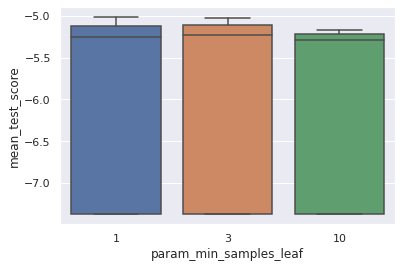

In [39]:
sns.boxplot(x = 'param_min_samples_leaf', y = 'mean_test_score', data = rf_cv_results)

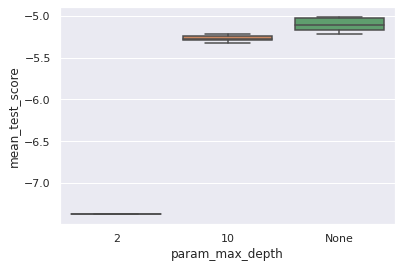

In [40]:
sns.boxplot(x = 'param_max_depth', y = 'mean_test_score', data = rf_cv_results)

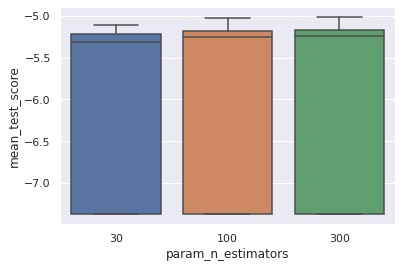

In [41]:
sns.boxplot(x = 'param_n_estimators', y = 'mean_test_score', data = rf_cv_results) # the outliers are the ones with max_depth 2

### Evaluation

In [45]:
y_pred_rf2 = model_rf2.predict(X_test)
err_rf2 = y_pred_rf2 - y_test

In [46]:
# to calculate MSE:
mean_squared_error(y_test, y_pred_rf2)

24.885093426833535

In [47]:
# to calculate RMSE:
mean_squared_error(y_test, y_pred_rf2, squared = False)

4.988496108731923

In [48]:
# to calculate R-squared:
r2_score(y_test, y_pred_rf2)

0.8458324818170894

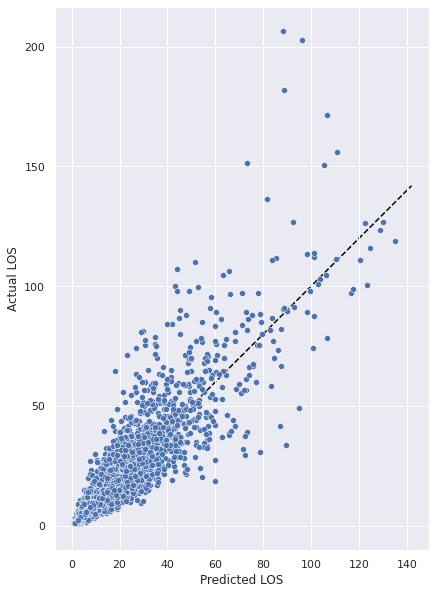

In [49]:
plt.figure(figsize = (10, 10))
g = sns.scatterplot(x = y_pred_rf2, y = y_test)
g.set(xlabel = 'Predicted LOS', ylabel = 'Actual LOS', aspect=1)

# add a predicted=actual line for clarity. Ideally predictions should be close to this line.
diag_line_coor = (0, min(g.get_xlim()[1], g.get_ylim()[1]))
plt.plot(diag_line_coor, diag_line_coor, color="black", ls="--", zorder=0)

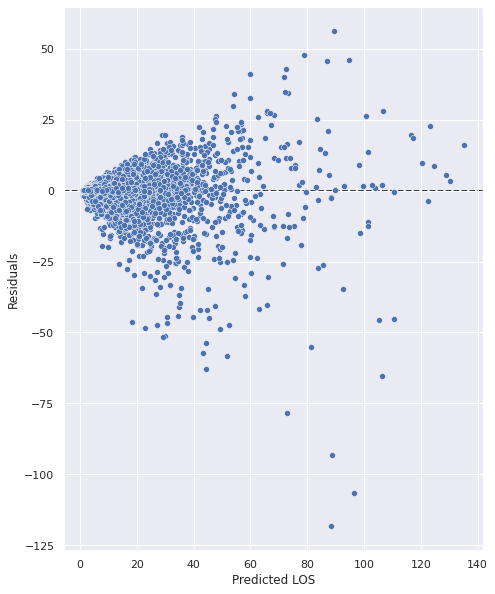

In [50]:
plt.figure(figsize = (10, 10))
g = sns.scatterplot(x = y_pred_rf2, y = err_rf2)
g.set(xlabel = 'Predicted LOS', ylabel = 'Residuals', aspect=1)

# add a horizontal line. Ideally predictions should be close to this line.
plt.axhline(y=0, color="black", ls="--", zorder=0)

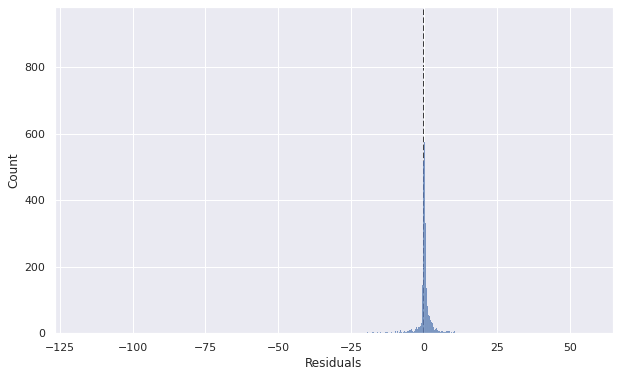

In [51]:
plt.figure(figsize = (10, 6))
g = sns.histplot(err_rf2)
g.set(xlabel = 'Residuals')

# add a vertical line. Ideally predictions should be close to this line.
plt.axvline(x=0, color="black", ls="--", zorder=0)

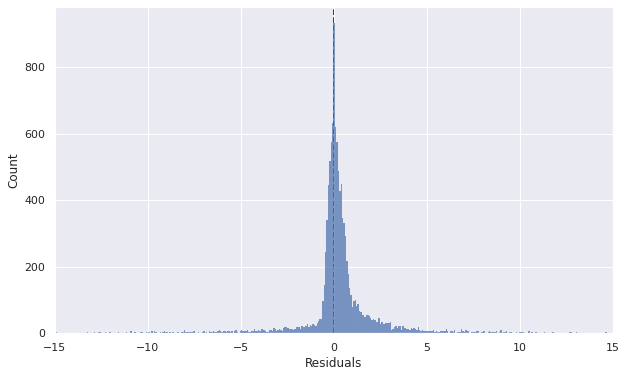

In [52]:
plt.figure(figsize = (10, 6))
g = sns.histplot(err_rf2)
g.set(xlabel = 'Residuals', xlim = (-15, 15)) # specify boundaries for x axis to zoom in

# add a vertical line. Ideally predictions should be close to this line.
plt.axvline(x=0, color="black", ls="--", zorder=0)

[Text(0, 0.5, 'Cumulative Percentage'),
 (0.0, 15.0),
 Text(0.5, 0, 'Absolute Residuals')]

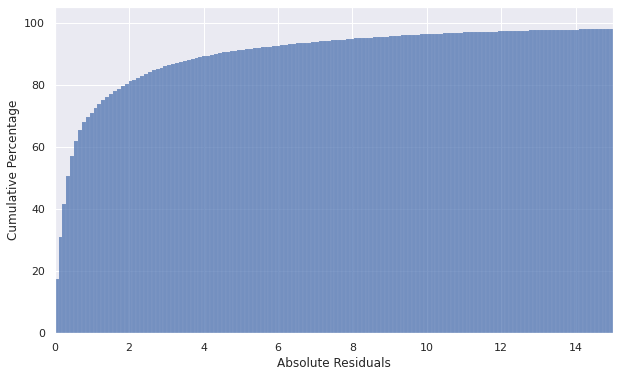

In [53]:
plt.figure(figsize = (10, 6))
g = sns.histplot(abs(err_rf2), cumulative = True, stat = 'percent')
g.set(xlabel = 'Absolute Residuals', ylabel = 'Cumulative Percentage', xlim = (0, 15))

**Some Observations**

* Model performance improved across all metrics. The model is able to predict LOS within a 2-hr difference 80% of the time.

---

## 2.5. Understanding a Random Forest Model

Similar to RF models for classification, **feature importance** can be a powerful tool to help you find insights in the model.

In [54]:
model_rf2_importance = pd.Series(model_rf2.feature_importances_, index = features_list)
model_rf2_importance

GENDER_F                            0.001521
AGE                                 0.009028
CALLOUT_COUNT_DAY                   0.046014
PRES_COUNT_DAY                      0.014902
PROC_COUNT_DAY                      0.079080
CPT_COUNT_DAY                       0.011708
LAB_COUNT_DAY                       0.019944
INPUTS_CV_COUNT_DAY                 0.011227
INPUTS_MV_COUNT_DAY                 0.003485
OUTPUT_COUNT_DAY                    0.021370
TRANSFER_COUNT_DAY                  0.735713
MICRO_COUNT_DAY                     0.016792
ADMISSION_TYPE_ELECTIVE             0.005178
ADMISSION_TYPE_EMERGENCY            0.001443
ADMISSION_TYPE_NEWBORN              0.000650
ADMISSION_TYPE_URGENT               0.000913
RELIGION_CATHOLIC                   0.001588
RELIGION_NOT SPECIFIED              0.001315
RELIGION_UNOBTAINABLE               0.000871
RELIGION_OTHERS                     0.001485
INSURANCE_Medicare                  0.000975
INSURANCE_Private                   0.001443
INSURANCE_

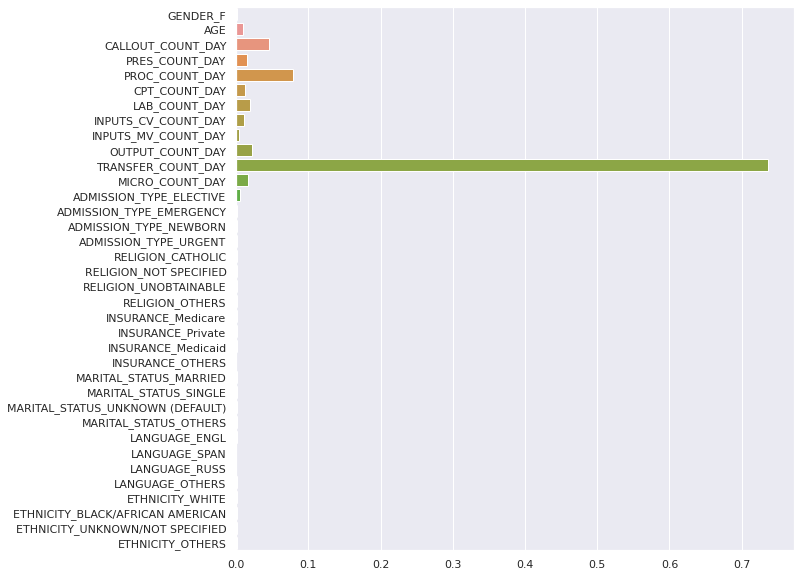

In [55]:
plt.figure(figsize = (10, 10))
sns.barplot(x = model_rf2.feature_importances_, y = features_list)

**Some Observations**

* This variable importance plot could be an evidence of the variable `TRANSFER_COUNT_DAY` being systematically tied to LOS due to their uniquely strong association. Note that `TRANSFER_COUNT` stands for the total number of change in physical locations for patients throughout their hospital stay ([documentation](https://mimic.mit.edu/docs/iii/tables/transfers/)), and `TRANSFER_COUNT_DAY` is the daily average version of it. 

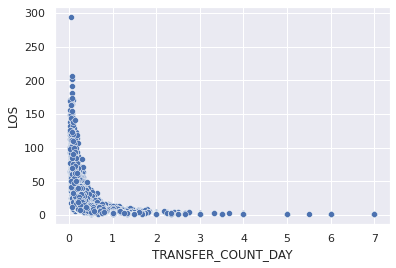

In [141]:
sns.scatterplot(x = 'TRANSFER_COUNT_DAY', y = 'LOS', data = df)

* The model likely learnt that any patients with `TRANSFER_COUNT_DAY` > 1 tends to have a short LOS. 

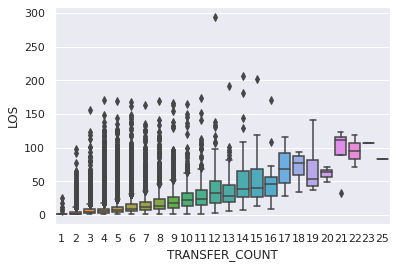

In [136]:
sns.boxplot(x = 'TRANSFER_COUNT', y = y_train, data = df)

---

## 2.6. Training a Neural Network

Neural network has been a backbone of many modern AI algorithms and has a wide spread of applications such as image recognition and natural language processing. 

In fact, neural networks for supervised learning, in their simpliest form, are very similar to linear or logistic regression models. Linear or logistic regression models cancan be thought of as a one-layer neural network; and neural networks can be thought of as multiple linear or logistic models being stacked and trained together. Of course, there are a lot of nuances when it comes to setting up and training a neural network but that would be beyond the scope of this tutorial here. 



<img src='https://cdnsciencepub.com/cms/10.1139/er-2020-0019/asset/images/large/er-2020-0019f2.jpeg' width='70%'> 

(Jain, 2020)


In [106]:
# 1. Specify a model to be trained
# Also define the configuration/hyperparameters of a random forest model. 
# Here we specify that the NN model contains 2 hidden layers with 20 and 5 nodes respectively. 
# All other parameters are set to default. 
model_nn = MLPRegressor(hidden_layer_sizes=(20, 5),
                        random_state = 1)

In [107]:
# 2. Train the model
%%time
model_nn.fit(X_train, y_train)

CPU times: user 32.2 s, sys: 6.24 ms, total: 32.2 s
Wall time: 32.4 s


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPRegressor(hidden_layer_sizes=(20, 5), random_state=1)

In [108]:
# 3. Make predictions
y_pred_nn = model_nn.predict(X_test)
y_pred_nn

array([ 94.20585032,   6.50644882, 111.54158685, ...,  12.15047657,
         1.31984965,   3.07791529])

In [109]:
err_nn = y_pred_nn - y_test # compute the residuals (error in prediction)

---

### Evaluation

In [110]:
# to calculate MSE:
mean_squared_error(y_test, y_pred_nn)

38.04144699269354

In [111]:
# to calculate RMSE:
mean_squared_error(y_test, y_pred_nn, squared = False)

6.1677748818105815

In [112]:
# to calculate R-squared:
r2_score(y_test, y_pred_nn)

0.7643265640856963

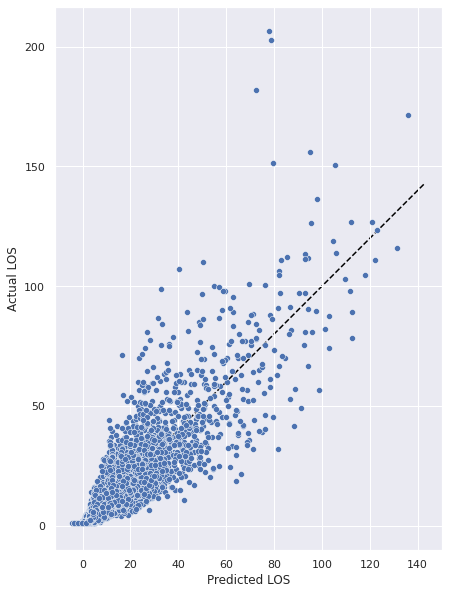

In [113]:
plt.figure(figsize = (10, 10))
g = sns.scatterplot(x = y_pred_nn, y = y_test)
g.set(xlabel = 'Predicted LOS', ylabel = 'Actual LOS', aspect=1)

# add a predicted=actual line for clarity. Ideally predictions should be close to this line.
diag_line_coor = (0, min(g.get_xlim()[1], g.get_ylim()[1]))
plt.plot(diag_line_coor, diag_line_coor, color="black", ls="--", zorder=0)

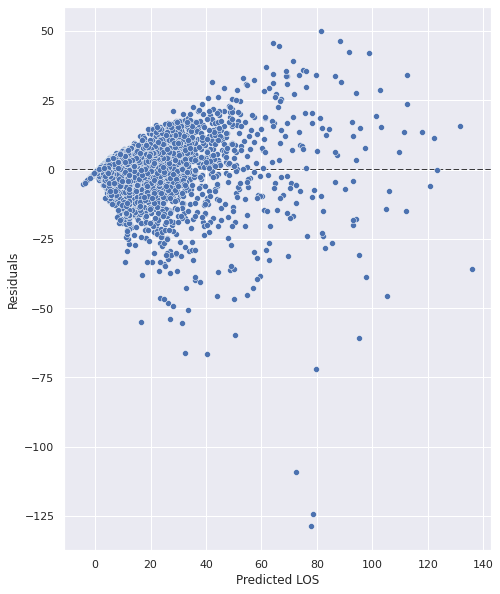

In [114]:
plt.figure(figsize = (10, 10))
g = sns.scatterplot(x = y_pred_nn, y = err_nn)
g.set(xlabel = 'Predicted LOS', ylabel = 'Residuals', aspect=1)

# add a horizontal line. Ideally predictions should be close to this line.
plt.axhline(y=0, color="black", ls="--", zorder=0)

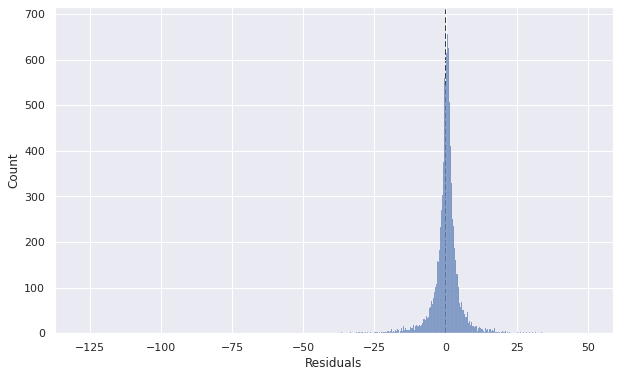

In [115]:
plt.figure(figsize = (10, 6))
g = sns.histplot(err_nn)
g.set(xlabel = 'Residuals')

# add a vertical line. Ideally predictions should be close to this line.
plt.axvline(x=0, color="black", ls="--", zorder=0)

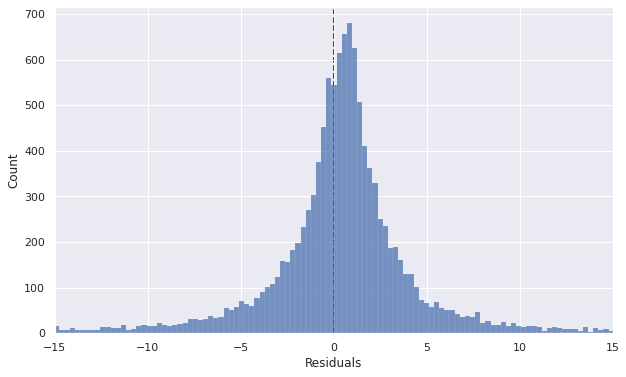

In [116]:
plt.figure(figsize = (10, 6))
g = sns.histplot(err_nn)
g.set(xlabel = 'Residuals', xlim = (-15, 15)) # specify boundaries for x axis to zoom in

# add a vertical line. Ideally predictions should be close to this line.
plt.axvline(x=0, color="black", ls="--", zorder=0)

[Text(0, 0.5, 'Cumulative Percentage'),
 (0.0, 15.0),
 Text(0.5, 0, 'Absolute Residuals')]

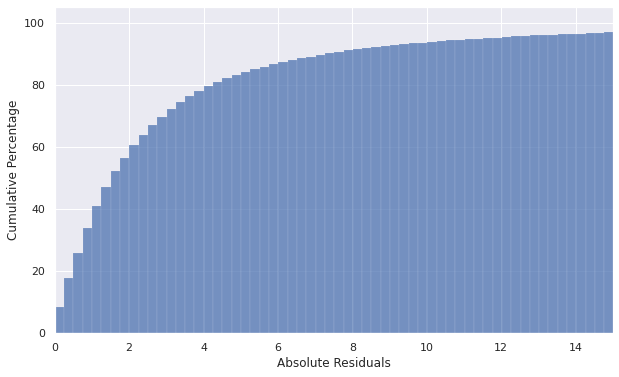

In [117]:
plt.figure(figsize = (10, 6))
g = sns.histplot(abs(err_nn), cumulative = True, stat = 'percent')
g.set(xlabel = 'Absolute Residuals', ylabel = 'Cumulative Percentage', xlim = (0, 15))

**Some Observations**

* The neural network is worse than both the tuned and untuned RF models. Tuning hyperparameters and including NN-specific pre-processing procedures are needed for it to produce good results. 

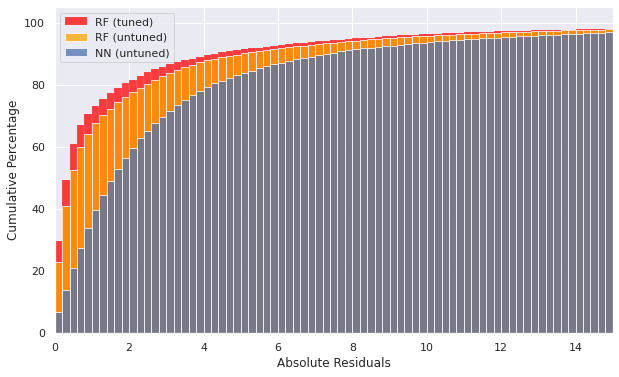

In [129]:
plt.figure(figsize = (10, 6))
sns.histplot(abs(err_rf2), cumulative = True, binwidth = .2, stat = 'percent', label = 'RF (tuned)',   color = 'red').set(xlabel = 'Absolute Residuals', ylabel = 'Cumulative Percentage', xlim = (0, 15))
sns.histplot(abs(err_rf1), cumulative = True, binwidth = .2, stat = 'percent', label = 'RF (untuned)', color = 'orange')
sns.histplot(abs(err_nn),  cumulative = True, binwidth = .2, stat = 'percent', label = 'NN (untuned)')
plt.legend() 

---

# References

* Jain, P., Coogan, S. C., Subramanian, S. G., Crowley, M., Taylor, S., & Flannigan, M. D. (2020). A review of machine learning applications in wildfire science and management. Environmental Reviews, 28(4), 478-505.